# Beer production analysis and forecast

## Initial exploration of the data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from datetime import datetime
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error

data = pd.read_csv("data/monthly-beer-production-in-austr.csv", delimiter = ",")
data.columns = ["month", "production"]

# get rid of the incomplete year in the end
data = data.iloc[:-8]

# convert the month column into datetime format
data["month"] = [datetime.strptime(i, "%Y-%m") for i in data["month"]]

# split the data into training and test sets
x_test = data.iloc[-12:]
x_train = data.iloc[:-12]

print(data.info())
display(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 468 entries, 0 to 467
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   month       468 non-null    datetime64[ns]
 1   production  468 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 7.4 KB
None


,month,production
0,1956-01-01,93.2
1,1956-02-01,96.0
2,1956-03-01,95.2
3,1956-04-01,77.1
4,1956-05-01,70.9
...,...,...
463,1994-08-01,143.0
464,1994-09-01,143.0
465,1994-10-01,160.0
466,1994-11-01,190.0


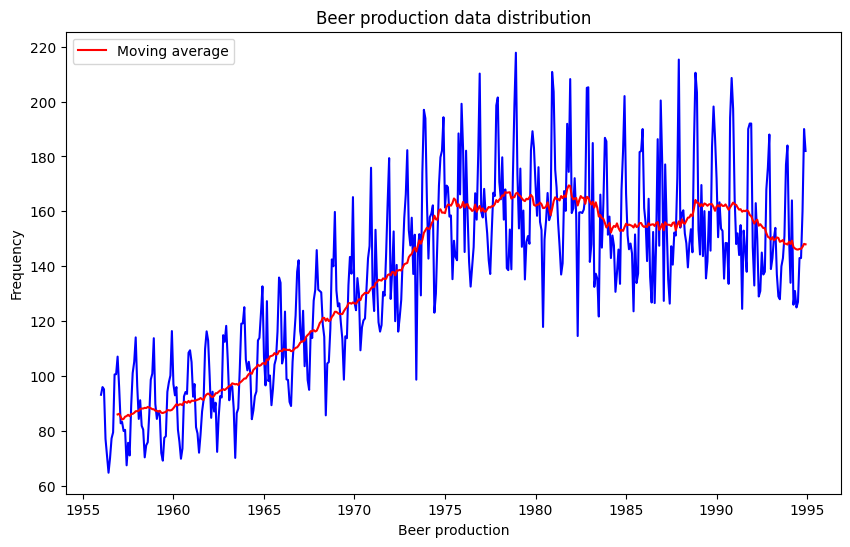

<Figure size 640x480 with 0 Axes>

In [2]:
plt.figure(figsize = (10, 6))
sns.lineplot(x = "month", y = "production", data = data, color = "blue")
sns.lineplot(x = data["month"], y = data["production"].rolling(12).mean(), color = "red", label = "Moving average")
plt.title("Beer production data distribution")
plt.ylabel("Frequency")
plt.xlabel("Beer production")
plt.legend()
plt.show()
plt.clf()

There are no missing values and no apparent outliers. Also, we can tell that:
- The data had an upwards trend that flatened at some point between 1975 and 1980.
- The data appears to be more volatile in the later years relative to the beginning of the series.
- A downwards trend appears to be showing towards the end of the distribution.

### Checking for outliers

While visually there don't appear to be outliers, we can conduct a more robust check using the IQR method

In [3]:
q1 = np.quantile(data["production"], 0.25)
q3 = np.quantile(data["production"], 0.75)
iqr = q3 - q1
outliers = 0

for i in data["production"]:
    if (i < (q1 - (iqr * 1.5))) or (i > (q3 + (iqr * 1.5))):
        print("The value at {} is an outlier".format(data["month"][data["production"].index(i)]))
        outliers += 1

if outliers != 0:
    print("{} outliers found".format(outliers))
else:
    print("No outliers found")

No outliers found


Even after double-checking with the IQR method, no outliers were found, so this is not something we're going to need to address later on when building our prediction model.

## Checking for stationarity

We'll start by visualizing the data

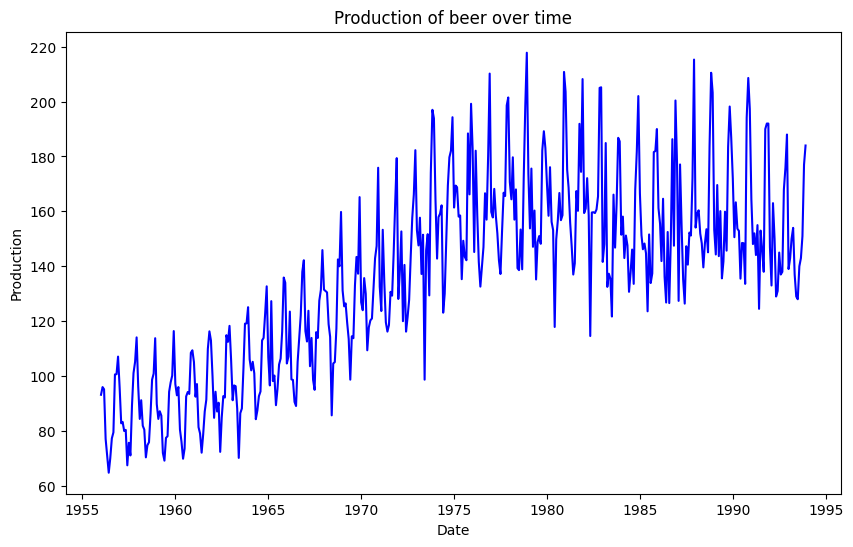

In [5]:
plt.figure(figsize = (10, 6))
sns.lineplot(x = "month", y = "production", data = x_train, color = "blue")
plt.xlabel("Date")
plt.ylabel("Production")
plt.title("Production of beer over time")
plt.show()

The time series doesn't seem stationary, but we'll double check by plotting the rolling mean and standard deviation and performing the ADF test.

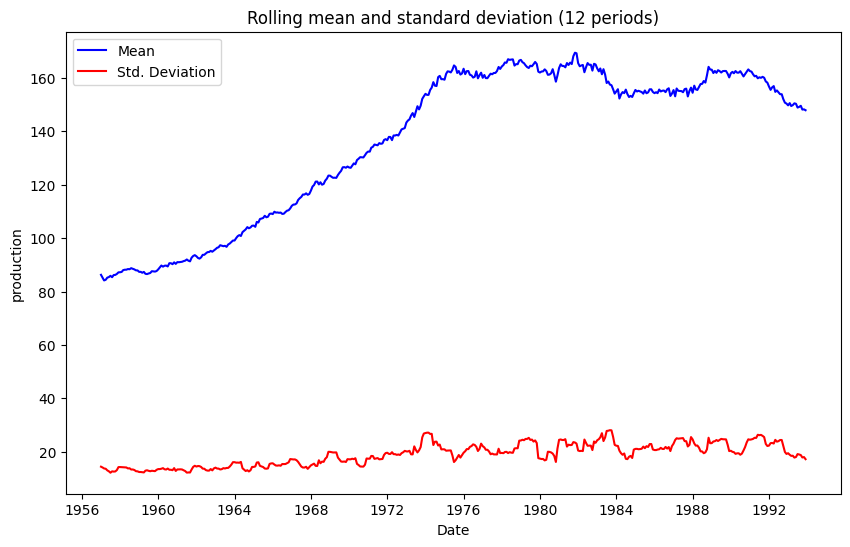

In [6]:
### plotting of the rolling mean and standard deviation
rolling_mean = x_train["production"].rolling(12).mean()
rolling_std = x_train["production"].rolling(12).std()

plt.figure(figsize = (10, 6))
sns.lineplot(x = x_train["month"].iloc[12:], y = rolling_mean, color = "blue", 
             label = "Mean")
sns.lineplot(x = x_train["month"].iloc[12:], y = rolling_std, color = "red",
             label = "Std. Deviation")
plt.title("Rolling mean and standard deviation (12 periods)")
plt.xlabel("Date")
plt.legend()
plt.show()

In [7]:
### ADF test for regular stationarity
adf_pval = adfuller(x_train["production"])
print("ADF test p-value: {}".format(adf_pval[1]))

### KPSS test for trend stationarity
kpss_pval = kpss(x_train["production"])
print("KPSS test p-value: {}".format(kpss_pval[1]))

ADF test p-value: 0.20100835622234758
KPSS test p-value: 0.01


C:\Users\david\AppData\Local\Temp\ipykernel_25196\591509021.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_pval = kpss(x_train["production"])


Visual inspection results:
- The dataset does not appear stationary when looking at it.
- The mean and standard deviation don't remain constant over time.

ADF test results:
- With a p-value of over 0.2, it's not possible to reject the null hypothesis, meaning the series is not stationary

KPSS test results:
- With a p-value of 0.01, we reject the null hypothesis of stationarity, meaning the series is also non-stationary in terms of trend

## Addressing non-stationarity

We can assess if differencing is needed by looking at the ACF plot

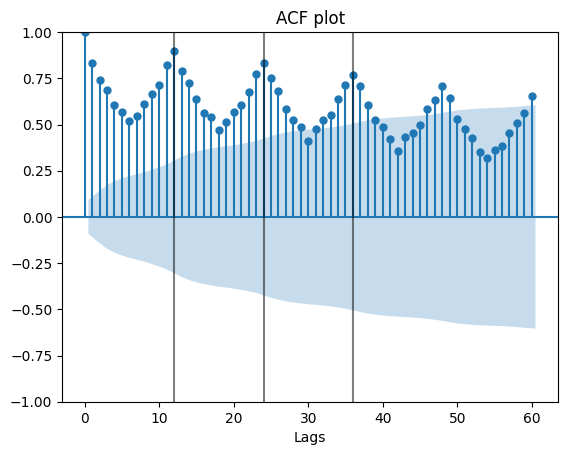

<Figure size 640x480 with 0 Axes>

In [4]:
### ACF plot
plot_acf(x_train["production"], lags = 60)
plt.axvline(12, color = "black", alpha = 0.5)
plt.axvline(24, color = "black", alpha = 0.5)
plt.axvline(36, color = "black", alpha = 0.5)
plt.title("ACF plot")
plt.xlabel("Lags")
plt.show()
plt.clf()

We'll address the non-constant variance first, then apply seasonal differencing, and, lastly, we'll perform regular differencing if it's still needed

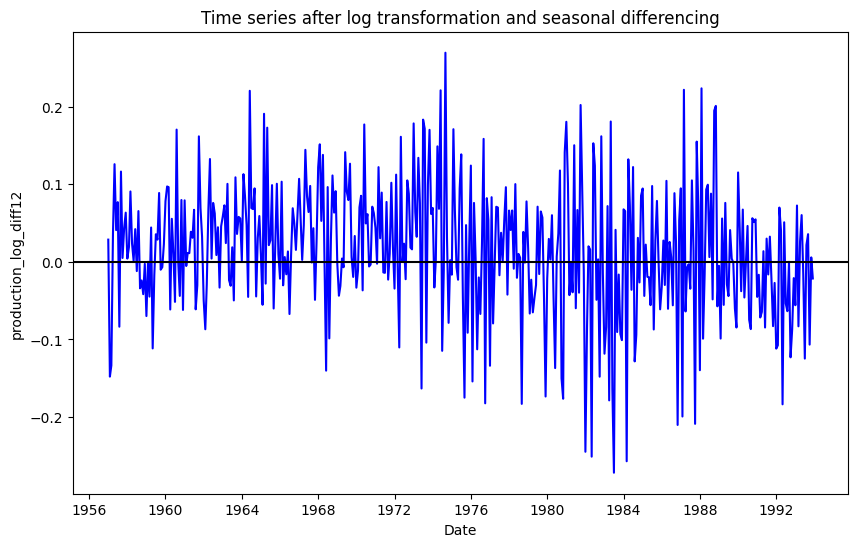

In [5]:
# apply the natural logarithm to address non-constant variance
x_train_log = pd.DataFrame({
    "month": x_train["month"],
    "production_log": x_train["production"].apply(np.log)
})

# apply seasonal differencing
x_train_log_diff12 = pd.DataFrame({
    "month": x_train["month"].iloc[12:, ],
    "production_log_diff12": x_train_log["production_log"].diff(12).dropna()
})

# inspecting the series
plt.figure(figsize = (10, 6))
sns.lineplot(x = "month", y = "production_log_diff12", data = x_train_log_diff12, color = "blue")
plt.axhline(0, color = "black")
plt.title("Time series after log transformation and seasonal differencing")
plt.xlabel("Date")
plt.show()

<Figure size 1000x600 with 0 Axes>

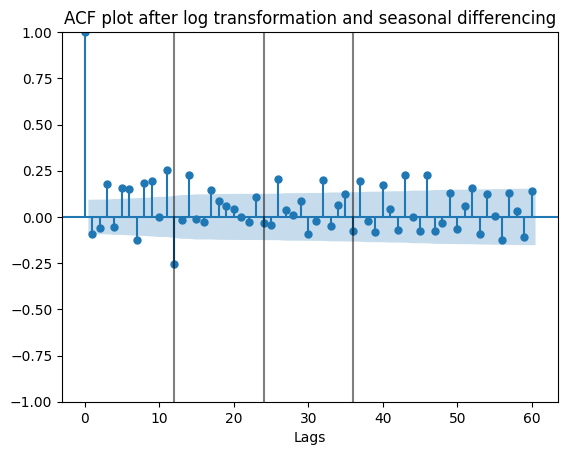

<Figure size 640x480 with 0 Axes>

In [6]:
### ACF of the transformed series
plt.figure(figsize = (10, 6))
plot_acf(x_train_log_diff12["production_log_diff12"], lags = 60)
plt.axvline(12, color = "black", alpha = 0.5)
plt.axvline(24, color = "black", alpha = 0.5)
plt.axvline(36, color = "black", alpha = 0.5)
plt.title("ACF plot after log transformation and seasonal differencing")
plt.xlabel("Lags")
plt.show()
plt.clf()

<Figure size 1000x600 with 0 Axes>

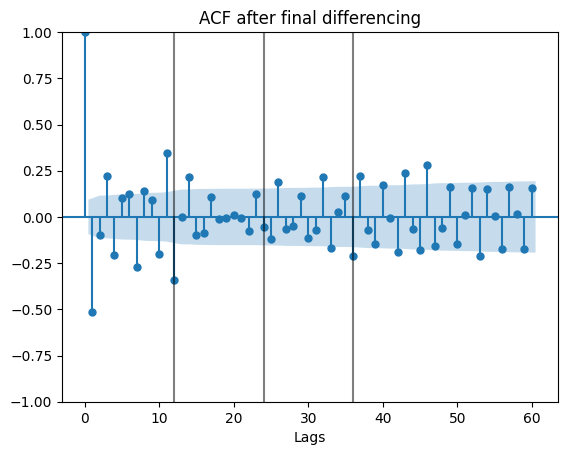

<Figure size 640x480 with 0 Axes>

In [7]:
# apply regular differencing
x_train_final_diff = pd.DataFrame({
    "month": x_train_log_diff12["month"].iloc[1:],
    "production_final_diff": x_train_log_diff12["production_log_diff12"].diff().dropna()
})

# plot the ACF once again
plt.figure(figsize = (10, 6))
plot_acf(x_train_final_diff["production_final_diff"], lags = 60)
plt.axvline(12, color = "black", alpha = 0.5)
plt.axvline(24, color = "black", alpha = 0.5)
plt.axvline(36, color = "black", alpha = 0.5)
plt.title("ACF after final differencing")
plt.xlabel("Lags")
plt.show()
plt.clf()

In [8]:
### double check with the ADF test
adf_pval_final = adfuller(x_train_final_diff["production_final_diff"])
print("ADF test p-value: {}".format(adf_pval_final[1]))

### double check with the KPSS test
kpss_pval_final = kpss(x_train_final_diff["production_final_diff"])
print("KPSS test p-value: {}".format(kpss_pval_final[1]))

ADF test p-value: 3.574762244677491e-14
KPSS test p-value: 0.1


C:\Users\david\AppData\Local\Temp\ipykernel_1236\1447271667.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_pval_final = kpss(x_train_final_diff["production_final_diff"])


The ACF is now droppping to zero relatively quickly, which suggests that the time series is now stationary.<br><br>
In addition, both the ADF and KPSS tests confirm that the data is stationary

## Determining the order of the autoregressive

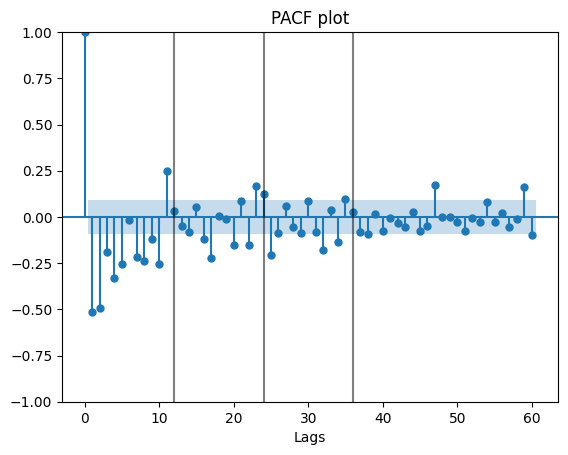

<Figure size 640x480 with 0 Axes>

In [9]:
plot_pacf(x_train_final_diff["production_final_diff"], lags = 60)
plt.axvline(12, color = "black", alpha = 0.5)
plt.axvline(24, color = "black", alpha = 0.5)
plt.axvline(36, color = "black", alpha = 0.5)
plt.title("PACF plot")
plt.xlabel("Lags")
plt.show()
plt.clf()

While the first three lags appear above the interval and then die down, we'll follow the principle of parsimony:
- Non-seasonal order (p = 2)
- Seasonal order (P = 1)

## Determining the order of the moving average

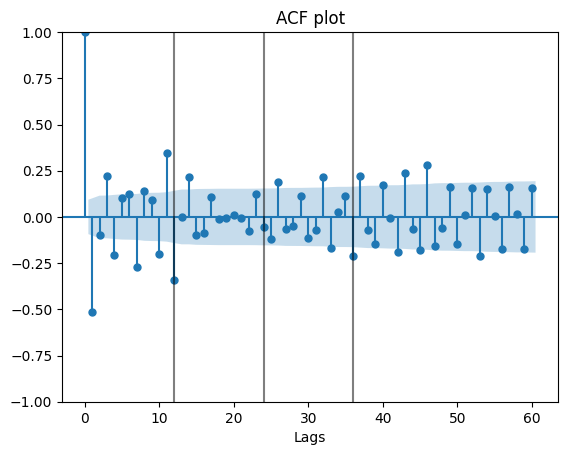

In [10]:
plot_acf(x_train_final_diff["production_final_diff"], lags = 60)
plt.axvline(12, color = "black", alpha = 0.5)
plt.axvline(24, color = "black", alpha = 0.5)
plt.axvline(36, color = "black", alpha = 0.5)
plt.title("ACF plot")
plt.xlabel("Lags")
plt.show()

The graph suggests the following orders:
- Non-seasonal order (q = 1)
- Seasonal order (Q = 1)

## Fitting the model

Putting everything together, we have the following:
- Non-seasonal parameters:
    - p = 2
    - d = 1
    - q = 1
- Seasonal parameters:
    - P = 1
    - D = 1
    - Q = 1

SARIMA(2, 1, 1)(1, 1, 1, 12)

In [16]:
# fit the model with the orders identified visually
sarima = SARIMAX(x_train_log["production_log"],
                 order = (2, 1, 1),
                 seasonal_order = (1, 1, 1, 12))
sarima = sarima.fit(disp = False)

print(sarima.summary())

                                     SARIMAX Results                                      
Dep. Variable:                     production_log   No. Observations:                  456
Model:             SARIMAX(2, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 557.469
Date:                           lu., 09 feb. 2026   AIC                          -1102.938
Time:                                    22:56:14   BIC                          -1078.376
Sample:                                         0   HQIC                         -1093.251
                                            - 456                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2288      0.045     -5.113      0.000      -0.316      -0.141
ar.L2         -0.1947      0.050   

By looking at the model's summary, we can see that all parameters are statistically significant.<br><br>
Now we need to see if the error terms are independent, as this is one of the key assumptions of SARIMA models.

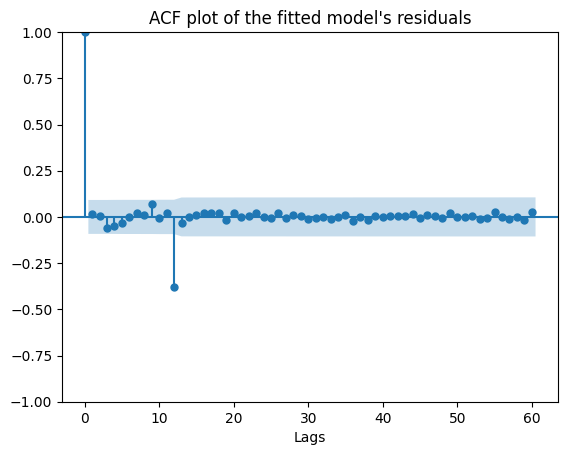

<Figure size 640x480 with 0 Axes>

In [17]:
# get the squared residuals
residuals = sarima.resid

# ACF plot of the squared residuals to check for correlation
plot_acf(residuals, lags = 60)
plt.title("ACF plot of the fitted model's residuals")
plt.xlabel("Lags")
plt.show()
plt.clf()

The very strong negative spike in lag 12 in the ACF plot suggests that the series might have been over-differenced, introducing negative autocorrelation where the differenced was performed.

In [18]:
# refitting the model without seasonal differencing
sarima_2 = SARIMAX(x_train_log["production_log"], 
                   order = (2, 1, 1), 
                   seasonal_order = (1, 0, 1, 12))
sarima_2 = sarima_2.fit(disp = False)

print(sarima_2.summary())

                                     SARIMAX Results                                      
Dep. Variable:                     production_log   No. Observations:                  456
Model:             SARIMAX(2, 1, 1)x(1, 0, 1, 12)   Log Likelihood                 559.050
Date:                           lu., 09 feb. 2026   AIC                          -1106.101
Time:                                    22:56:16   BIC                          -1081.379
Sample:                                         0   HQIC                         -1096.361
                                            - 456                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1973      0.046     -4.269      0.000      -0.288      -0.107
ar.L2         -0.1668      0.049   

c:\Users\david\OneDrive\Escritorio\Trabajo\Python\0_portfolio_projects\3_time_series_beer\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


All model parameters are still statistically significant, with the seasonal AR term even obtaining a lower p-value this time.

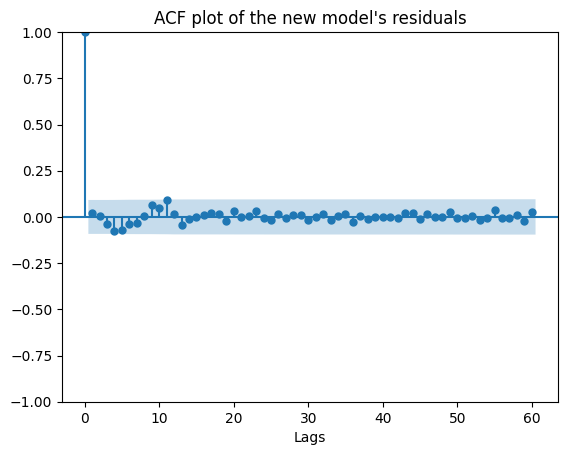

{'trend': 0, 'exog': 0, 'ar': 2, 'ma': 1, 'seasonal_ar': 12, 'seasonal_ma': 12, 'reduced_ar': 14, 'reduced_ma': 13, 'exog_variance': 0, 'measurement_variance': 0, 'variance': 1}


<Figure size 640x480 with 0 Axes>

In [19]:
# get the model's residuals
residuals_2 = sarima_2.resid

# ACF plot of the new model's residuals
plot_acf(residuals_2, lags = 60)
plt.title("ACF plot of the new model's residuals")
plt.xlabel("Lags")
plt.show()
plt.clf()

print(sarima_2.model_orders)

We can double check that residuals are not correlated with the Ljung-Box test, for which:<br>
H<sub>0</sub>: Data is not correlated<br>
H<sub>1</sub>: Data exhibits serial correlation

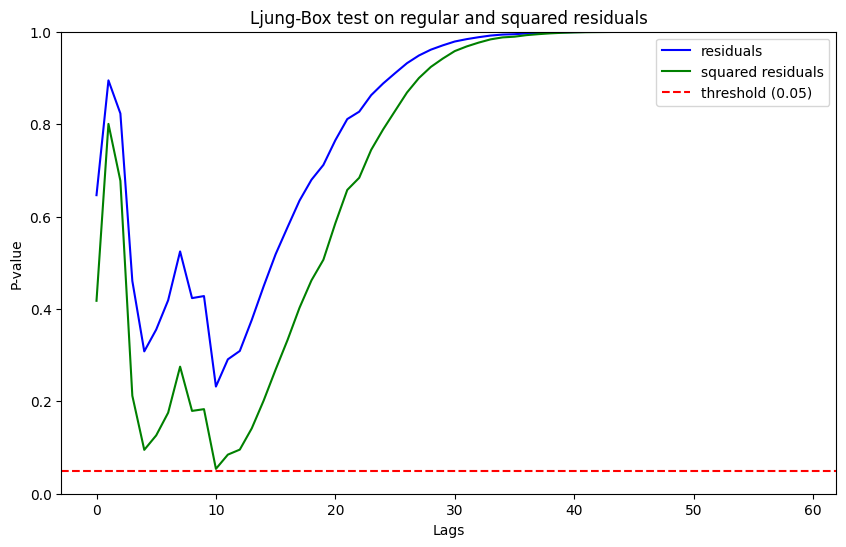

0.053812430804112785


In [20]:
# double check residual independence with the Ljung-Box test
lb_test = acorr_ljungbox(residuals_2, lags = 60)

plt.figure(figsize = (10, 6))
sns.lineplot(x = range(len(lb_test["lb_pvalue"])), 
             y = lb_test["lb_pvalue"], 
             color = "blue",
             label = "residuals")
sns.lineplot(x = range(len(lb_test["lb_pvalue"])),
             y = lb_test["lb_pvalue"] ** 2,
             color = "green",
             label = "squared residuals")
plt.axhline(0.05, color = "red", linestyle = "dashed", label = "threshold (0.05)")
plt.legend()
plt.title("Ljung-Box test on regular and squared residuals")
plt.ylabel("P-value")
plt.xlabel("Lags")
plt.ylim(0, 1)
plt.show()

print(min(lb_test["lb_pvalue"] ** 2))

It's not possible to reject the null hypothesis, so we can assume that the data is not correlated

## Grid search to corroborate the model parameters

In addition to visually determining what the best parameters might be for the model, we can also perform a grid search to see what the optimal combination of parameters could be.<br><br>
The criterion to select the best model will be the AIC, as it favors predictive capability rather than model simplicity.

In [ ]:
best_aic = float("inf")
p = range(0, 6)
d = range(0, 3)
q = range(0, 4)
P = range(0, 3)
D = range(0, 2)
Q = range(0, 3)
s = 12

parameters = list(itertools.product(p, d, q, P, D, Q))
best_model = None
best_order = None
best_seasonal_order = None

for param in parameters:
    # establish the parameters for the current iteration
    order = (param[0], param[1], param[2])
    seasonal_order = (param[3], param[4], param[5], s)

    try:
        # instantiate and fit the model
        model = SARIMAX(x_train_log["production_log"],
                        order = order,
                        seasonal_order = seasonal_order)
        results = model.fit(disp = False)

        # determine if the model is better
        if results.aic < best_aic:
            best_aic = results.aic
            best_model = results
            best_order = order
            best_seasonal_order = seasonal_order
    except:
        continue

print("Best model: {}\n".format(best_model))
print("Best regular parameters: {}\n".format(best_order))
print("Best seasonal parameters: {}".format(best_seasonal_order))

c:\Users\david\OneDrive\Escritorio\Trabajo\Python\0_portfolio_projects\3_time_series_beer\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
c:\Users\david\OneDrive\Escritorio\Trabajo\Python\0_portfolio_projects\3_time_series_beer\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
c:\Users\david\OneDrive\Escritorio\Trabajo\Python\0_portfolio_projects\3_time_series_beer\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
c:\Users\david\OneDrive\Escritorio\Trabajo\Python\0_portfolio_proj

With the grid search concluded, we obtain the following results:
- Non-seasonal parameters.
    - p = 4
    - d = 1
    - q = 3
- Seasonal parameters.
    - P = 1
    - D = 0
    - Q = 2

SARIMA(4, 1, 3)(1, 0, 2, 12)

In [ ]:
sarima_gs = SARIMAX(x_train_log["production_log"],
                    order = (4, 1, 3),
                    seasonal_order = (1, 0, 2, 12))
sarima_gs = sarima_gs.fit(disp = False)

print(sarima_gs.summary())

print("AIC value for the manually selected model: {}".format(sarima_2.aic))
print("AIC value for the grid search model: {}".format(sarima_gs.aic))

c:\Users\david\OneDrive\Escritorio\Trabajo\Python\0_portfolio_projects\7_time_series_beer\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\david\OneDrive\Escritorio\Trabajo\Python\0_portfolio_projects\7_time_series_beer\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\david\OneDrive\Escritorio\Trabajo\Python\0_portfolio_projects\7_time_series_beer\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                        SARIMAX Results                                        
Dep. Variable:                          production_log   No. Observations:                  456
Model:             SARIMAX(4, 1, 3)x(1, 0, [1, 2], 12)   Log Likelihood                 594.261
Date:                                 Thu, 18 Dec 2025   AIC                          -1166.522
Time:                                         16:11:38   BIC                          -1121.198
Sample:                                              0   HQIC                         -1148.666
                                                 - 456                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0524      0.051    -20.768      0.000      -1.152      -0

While the grid search model does have a lower AIC value, two things about it stand out:
- It's more complex than the manually chosen one.
    - Following the parsimony principle, we favor simpler models.
- Some of its parameters are no statistically signficant (ar.L3, ma.L2, and ma.S.L24).

We can evaluate how both of these perform and how well they generalize to unseen data, but this is something worth keeping in mind.

## Model validation (test set)

### Manually chosen model

We can test the model's performance by calculating the mean squared error (MSE) using the test data.<br><br>
It's important to keep in mind that, since a log transformation was applied on the data to address the non-constant variance, predictions have to be scaled back for them to be comparable with the test data.

Mean Squared Error for the manually chosen model: 77.66064968183333


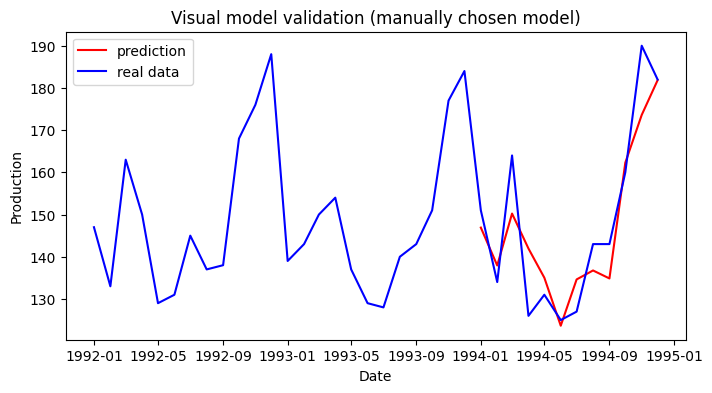

<Figure size 640x480 with 0 Axes>

In [ ]:
### SARIMA(2, 1, 1)(1, 0, 1, 12)
pred = np.exp(sarima_2.get_forecast(steps = len(x_test["production"])).predicted_mean)
mse = mean_squared_error(x_test["production"], pred)
print("Mean Squared Error for the manually chosen model: {}".format(mse))

# plot the predictions against the actual test data
plt.figure(figsize = (8, 4))
sns.lineplot(x = data["month"][-36:],
             y = pred,
             color = "red",
             label = "prediction")
sns.lineplot(x = data["month"][-36:],
             y = data["production"][-36:],
             color = "blue",
             label = "real data")
plt.title("Visual model validation (manually chosen model)")
plt.xlabel("Date")
plt.ylabel("Production")
plt.legend()
plt.show()
plt.clf()

### Grid search model

Mean Squared Error for grid search model: 80.29697018217531


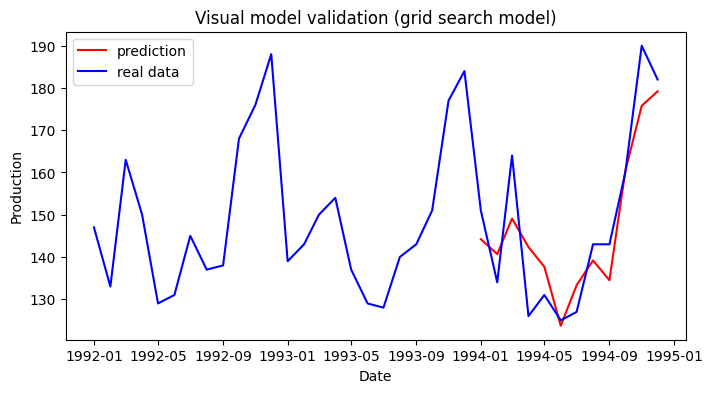

<Figure size 640x480 with 0 Axes>

In [ ]:
### SARIMA(4, 1, 3)(1, 0, 2, 12)
pred_gs = np.exp(sarima_gs.get_forecast(steps = len(x_test["production"])).predicted_mean)
mse_gs = mean_squared_error(x_test["production"], pred_gs)
print("Mean Squared Error for grid search model: {}".format(mse_gs))

# plot the predictions against the real data
plt.figure(figsize = (8, 4))
sns.lineplot(x = data["month"][-36:],
             y = pred_gs,
             color = "red",
             label = "prediction")
sns.lineplot(x = data["month"][-36:],
             y = data["production"][-36:],
             color = "blue",
             label = "real data")
plt.title("Visual model validation (grid search model)")
plt.ylabel("Production")
plt.xlabel("Date")
plt.legend()
plt.show()
plt.clf()

While the grid search model had a lower AIC value, it also had a higher MSE, indicating poorer performance relative to the manually chosen model.<br><br>
In addition, the visual inspection of the forecasted data for the grid search model suggests that the pattern is not being captured as well as with the initial model.

## Final validation

At the beginning of the project, a portion of the data was cut. This corresponded to an unfinished year at the end of the dataset (8 months to be precise).<br><br>
In addition to the test set validation, we can also compare how well the model generalizes to this data.

c:\Users\david\OneDrive\Escritorio\Trabajo\Python\0_portfolio_projects\7_time_series_beer\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 102.73507469716341


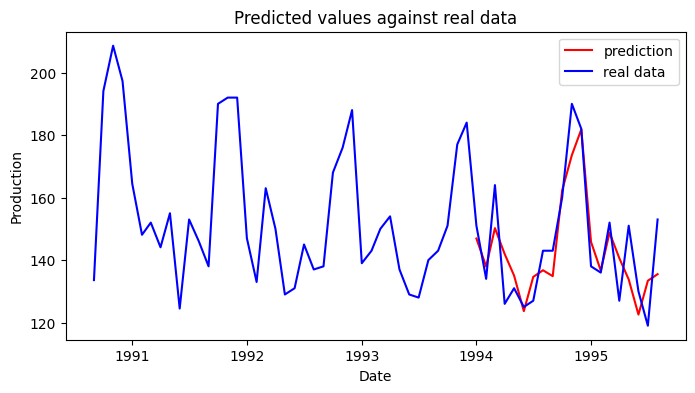

<Figure size 640x480 with 0 Axes>

In [ ]:
# predictions
pred_final = np.exp(sarima_2.get_forecast(steps = 20).predicted_mean)

# retrieve the 8 rows of data that were initially excluded
excluded_data = pd.read_csv("monthly-beer-production-in-austr.csv", delimiter = ",")
excluded_data = excluded_data[-60:]
excluded_data.columns = ["month", "production"]
excluded_data["month"] = [datetime.strptime(i, "%Y-%m") for i in excluded_data["month"]]

# mean squared error
mse_final = mean_squared_error(excluded_data["production"][-20:], pred_final)
print("Mean Squared Error: {}".format(mse_final))

# plot predictions against actual data
plt.figure(figsize = (8, 4))
sns.lineplot(x = excluded_data["month"],
             y = pred_final,
             color = "red",
             label = "prediction")
sns.lineplot(x = excluded_data["month"],
             y = excluded_data["production"],
             color = "blue",
             label = "real data")
plt.title("Predicted values against real data")
plt.ylabel("Production")
plt.xlabel("Date")
plt.legend()
plt.show()
plt.clf()

While the MSE increased sligthly, that is to be expected from a prediction further in the future.